In [1]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

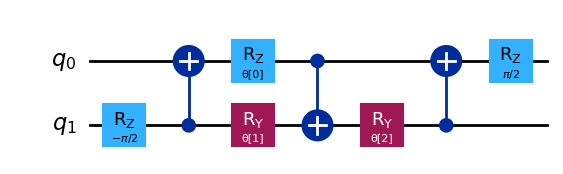

In [2]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

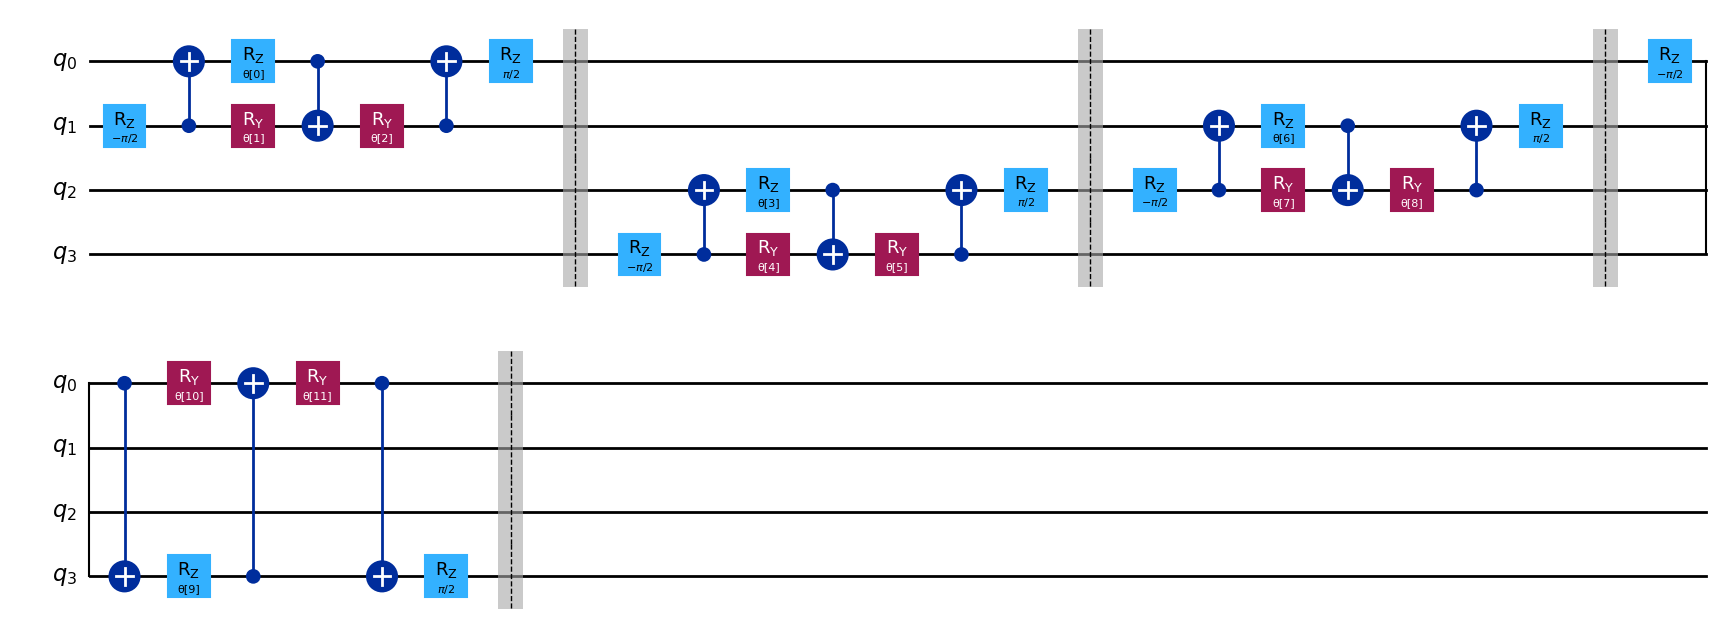

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

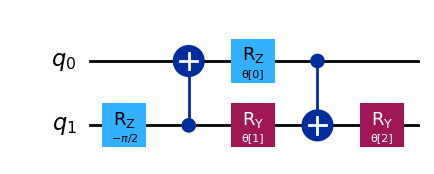

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

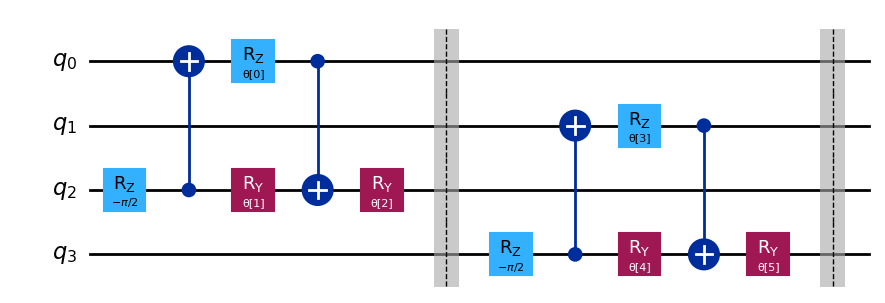

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
import tensorflow as tf
import collections
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-11-24 22:01:24.424552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732514484.437455   91891 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732514484.441056   91891 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:01:24.453436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [8]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


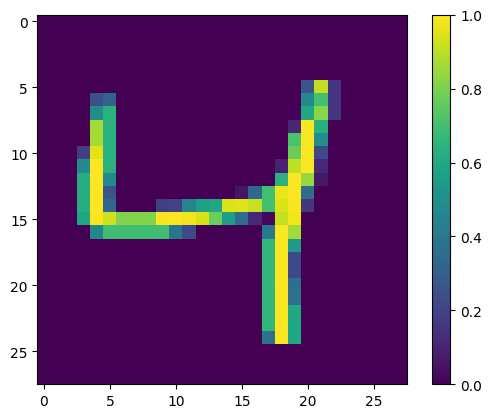

In [9]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [10]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

W0000 00:00:1732514486.406693   91891 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4


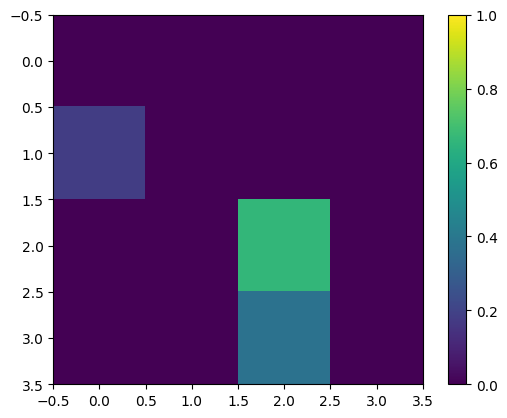

In [11]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    # num_uniq_c = sum(1 for value in mapping.values() if len(value) == 1 and c in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    # print("Number of unique ", c, "'s: ", num_uniq_c)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [13]:
import collections

resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 10254
Number of unique  3 's:  4798
Number of unique  4 's:  5293
Number of unique contradicting labels:  163

Initial number of images:  11973
Remaining non-contradicting unique images:  10091
Number of unique images: 1833
Number of unique  3 's:  869
Number of unique  4 's:  952
Number of unique contradicting labels:  12

Initial number of images:  1992
Remaining non-contradicting unique images:  1821


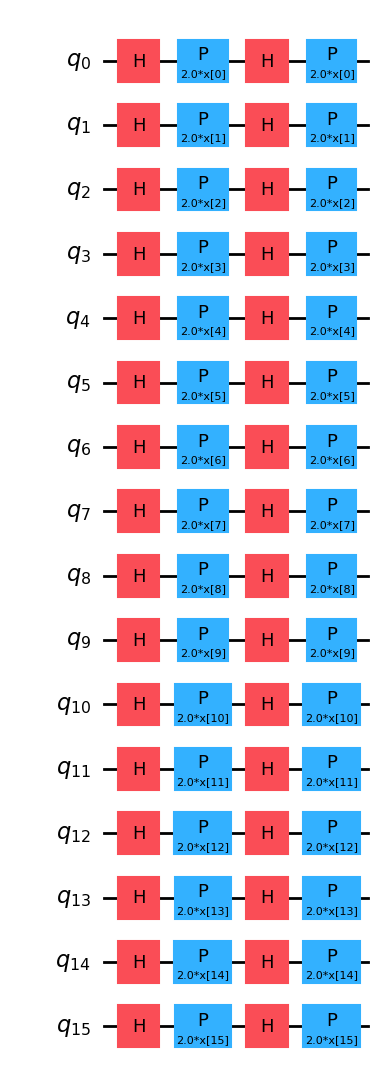

In [14]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

In [15]:
from qiskit_aer.primitives import Estimator

feature_map = ZFeatureMap(16)

ansatz = QuantumCircuit(16, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable1 = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

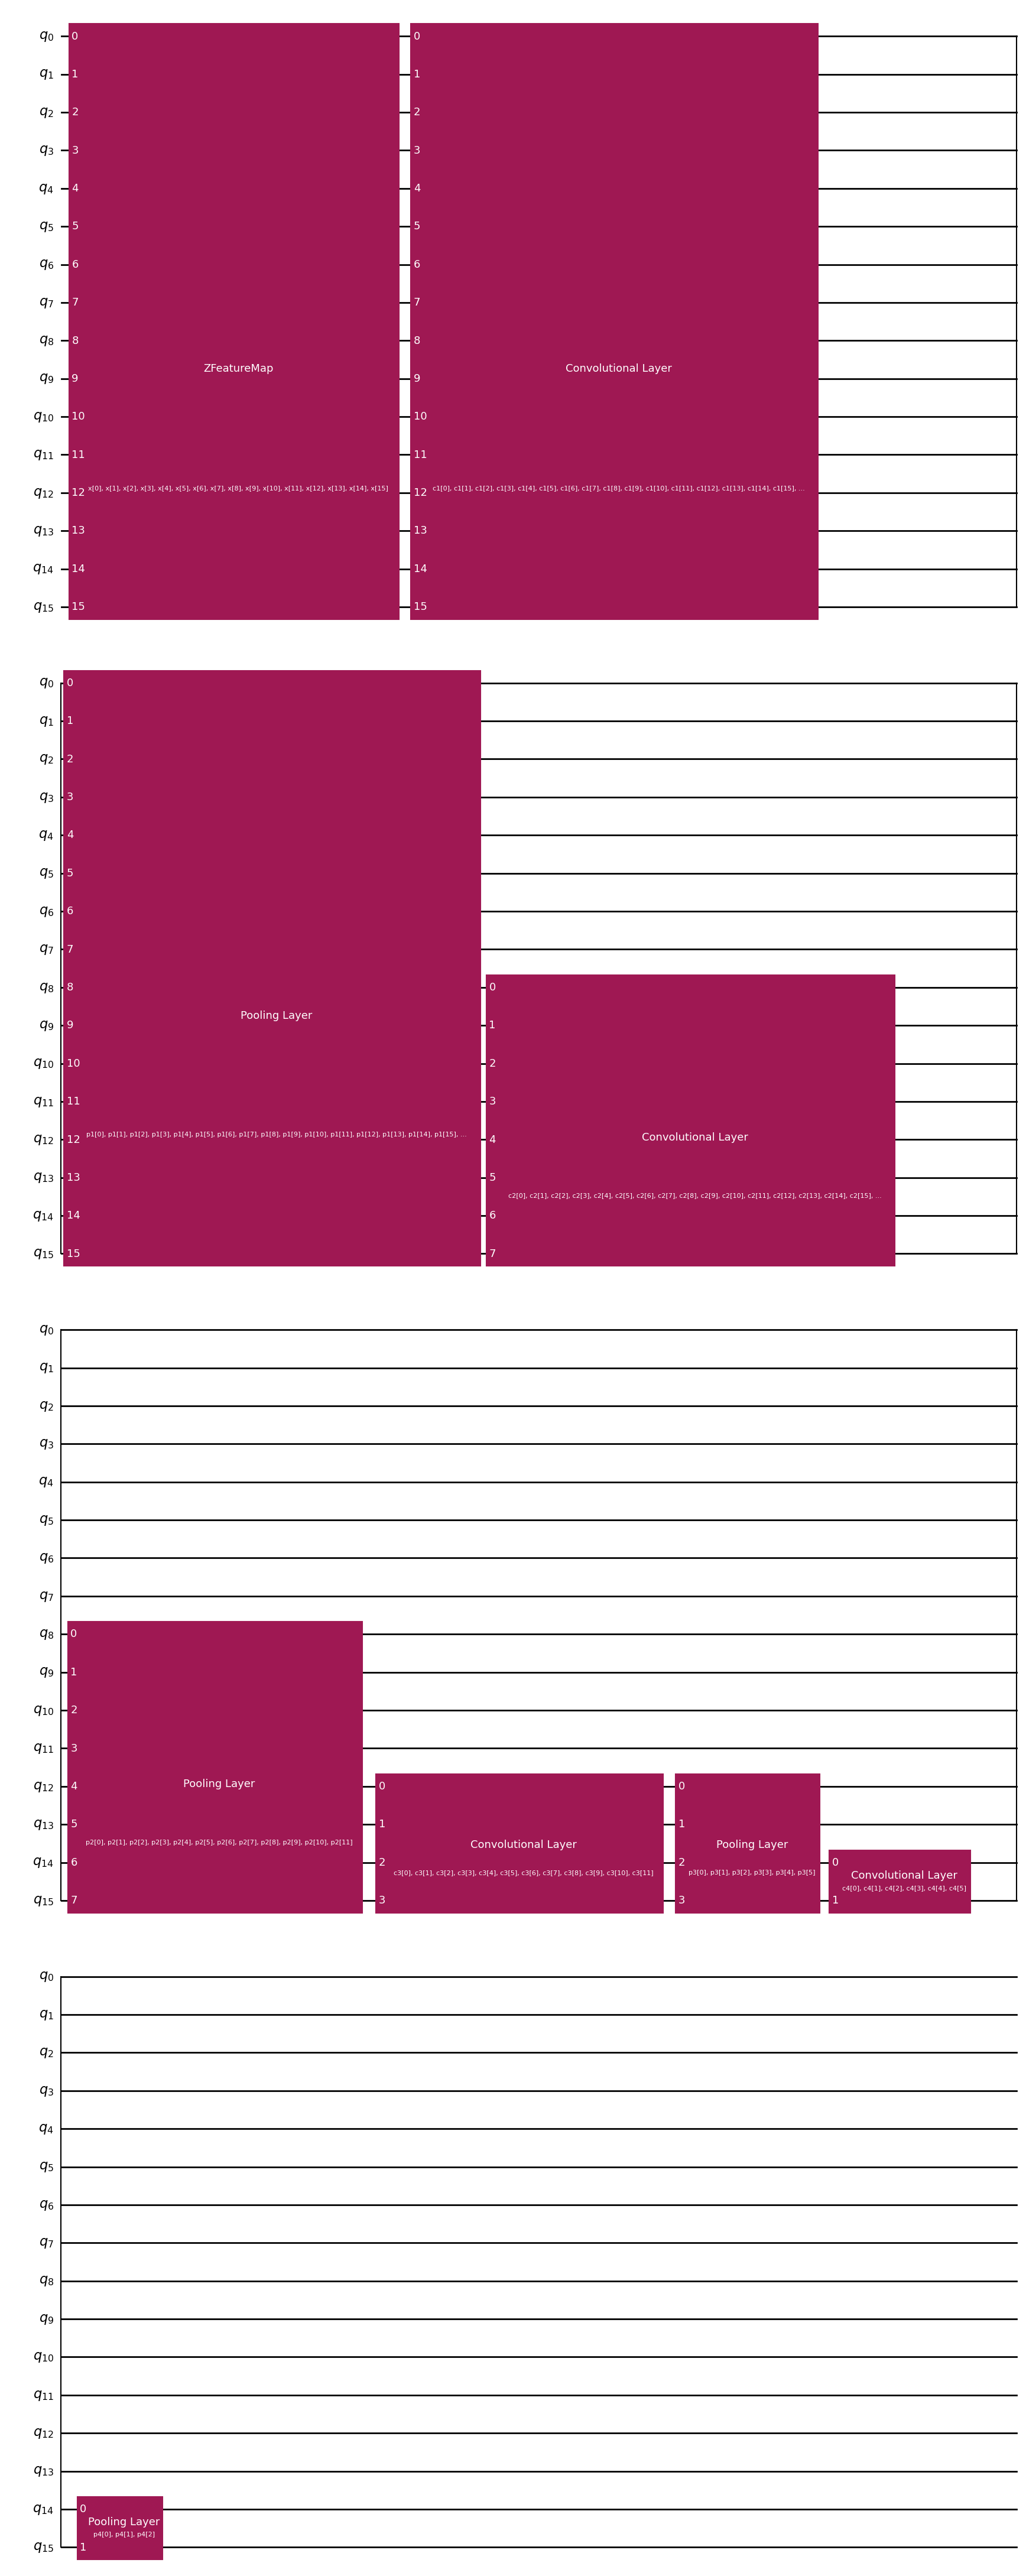

In [16]:
circuit.draw("mpl")

In [17]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
# avg_training_time per iteration = 7 minutes

cpt_50 = [1.44448154e+00,1.33485278e+00,5.56752779e-01,7.32868892e-01
,1.22204282e+00,4.66528949e-01,7.67711221e-01,7.57709386e-02
,1.82497615e+00,1.66146116e+00,4.52159426e-01,3.39690387e-01
,7.55127666e-01,1.26746274e+00,1.75572462e+00,1.45795347e+00
,1.55626021e+00,3.20562344e-01,8.57404485e-01,3.38863527e-01
,6.52012432e-01,2.61669027e-01,1.49827511e+00,1.54942722e+00
,1.09753554e+00,1.41120343e-01,5.72217702e-01,1.29493599e+00
,1.15093098e+00,2.16516673e-01,1.49723111e+00,1.99282190e+00
,1.41920391e+00,4.46920688e-01,1.77360347e+00,4.51988983e-01
,7.49820508e-01,4.53620578e-01,4.63347418e-01,1.02503454e+00
,6.98676526e-01,8.73971401e-01,9.00311007e-01,8.12653142e-01
,1.70566635e+00,1.63372030e+00,1.99631290e+00,1.47527095e+00
,7.57769753e-01,3.58837176e-01,1.51239348e-01,6.32423121e-01
,5.23771802e-01,9.10144785e-02,7.84132758e-01,4.47152675e-01
,4.45684221e-01,5.79263517e-01,6.63322440e-01,8.10920470e-01
,5.60394135e-01,9.39877134e-01,4.05329922e-02,8.51137552e-01
,4.53416358e-01,4.55747615e-01,2.69546877e-01,4.27001021e-01
,1.96394280e-01,7.72853452e-01,6.93293472e-01,1.68700625e-01
,1.47353722e-01,7.44382333e-01,8.14604681e-01,7.23410137e-01
,5.53710394e-02,3.77179208e-01,1.01736850e-01,4.20432059e-01
,5.94538461e-01,9.36136592e-01,4.00188836e-01,3.59757540e-02
,4.27791166e-01,8.44901368e-01,2.49607861e-01,8.25457331e-01
,5.18479639e-01,2.09750385e-01,9.58684022e-01,9.07917422e-01
,9.37833466e-02,4.93562679e-01,6.79180220e-01,8.10896053e-01
,8.82081909e-01,2.56937382e-01,4.65340875e-01,2.05890668e-01
,4.65168792e-01,6.44175369e-01,8.32559196e-01,2.08490239e-04
,5.35972833e-01,9.86121393e-01,3.14645220e-01,3.70165937e-01
,2.95556747e-01,5.43582124e-01,4.77490894e-01,8.28241910e-01
,9.26955568e-01,8.15256680e-01,2.89298320e-01,9.86836065e-01
,7.63890422e-01,8.37864939e-01,9.41930470e-01,2.44315946e-02
,5.43194125e-01,4.69374441e-01,6.78211097e-02,9.59601368e-01
,4.50301808e-01,9.63430846e-01,1.95174499e-01,5.03446303e-01
,6.88200378e-02,6.19632472e-01,1.43793795e-01,6.14324034e-01
,7.26689023e-01,8.51543664e-01,2.86667813e-01]

cpt_150 = [1.44448154e+00, 1.33485278e+00, 5.56752779e-01, 7.32868892e-01,
       1.22204282e+00, 1.46652895e+00, 7.67711221e-01, 1.07577094e+00,
       1.82497615e+00, 1.66146116e+00, 4.52159426e-01, 3.39690387e-01,
       7.55127666e-01, 1.26746274e+00, 2.75572462e+00, 2.45795347e+00,
       1.55626021e+00, 1.32056234e+00, 8.57404485e-01, 3.38863527e-01,
       6.52012432e-01, 2.61669027e-01, 1.49827511e+00, 1.54942722e+00,
       2.09753554e+00, 1.41120343e-01, 5.72217702e-01, 1.29493599e+00,
       1.15093098e+00, 2.16516673e-01, 1.49723111e+00, 1.99282190e+00,
       1.41920391e+00, 4.46920688e-01, 2.77360347e+00, 4.51988983e-01,
       7.49820508e-01, 4.53620578e-01, 4.63347418e-01, 1.02503454e+00,
       6.98676526e-01, 8.73971401e-01, 9.00311007e-01, 8.12653142e-01,
       1.70566635e+00, 1.63372030e+00, 1.99631290e+00, 1.47527095e+00,
       7.57769753e-01, 3.58837176e-01, 1.51239348e-01, 6.32423121e-01,
       5.23771802e-01, 1.09101448e+00, 1.78413276e+00, 4.47152675e-01,
       4.45684221e-01, 5.79263517e-01, 1.66332244e+00, 8.10920470e-01,
       5.60394135e-01, 9.39877134e-01, 4.05329922e-02, 8.51137552e-01,
       4.53416358e-01, 4.55747615e-01, 2.69546877e-01, 4.27001021e-01,
       1.19639428e+00, 7.72853452e-01, 6.93293472e-01, 1.16870063e+00,
       1.47353722e-01, 7.44382333e-01, 1.81460468e+00, 7.23410137e-01,
       5.53710394e-02, 3.77179208e-01, 1.01736850e-01, 4.20432059e-01,
       1.59453846e+00, 1.93613659e+00, 4.00188836e-01, 3.59757540e-02,
       4.27791166e-01, 8.44901368e-01, 2.49607861e-01, 1.82545733e+00,
       5.18479639e-01, 2.09750385e-01, 9.58684022e-01, 9.07917422e-01,
       9.37833466e-02, 4.93562679e-01, 6.79180220e-01, 8.10896053e-01,
       8.82081909e-01, 2.56937382e-01, 4.65340875e-01, 2.05890668e-01,
       4.65168792e-01, 6.44175369e-01, 8.32559196e-01, 2.08490239e-04,
       5.35972833e-01, 9.86121393e-01, 3.14645220e-01, 3.70165937e-01,
       2.95556747e-01, 5.43582124e-01, 4.77490894e-01, 8.28241910e-01,
       9.26955568e-01, 8.15256680e-01, 2.89298320e-01, 9.86836065e-01,
       7.63890422e-01, 8.37864939e-01, 9.41930470e-01, 2.44315946e-02,
       5.43194125e-01, 4.69374441e-01, 6.78211097e-02, 9.59601368e-01,
       4.50301808e-01, 9.63430846e-01, 1.95174499e-01, 5.03446303e-01,
       6.88200378e-02, 6.19632472e-01, 1.43793795e-01, 6.14324034e-01,
       7.26689023e-01, 8.51543664e-01, 2.86667813e-01]

cpt_250 = [1.44448154e+00, 1.33485278e+00, 5.56752779e-01, 7.32868892e-01,
       1.22204282e+00, 1.46652895e+00, 7.67711221e-01, 1.07577094e+00,
       1.82497615e+00, 1.66146116e+00, 4.52159426e-01, 3.39690387e-01,
       7.55127666e-01, 1.26746274e+00, 2.75572462e+00, 2.45795347e+00,
       1.55626021e+00, 1.32056234e+00, 8.57404485e-01, 3.38863527e-01,
       6.52012432e-01, 2.61669027e-01, 1.49827511e+00, 1.54942722e+00,
       2.09753554e+00, 1.41120343e-01, 5.72217702e-01, 1.29493599e+00,
       1.15093098e+00, 2.16516673e-01, 1.49723111e+00, 1.99282190e+00,
       1.41920391e+00, 4.46920688e-01, 2.77360347e+00, 4.51988983e-01,
       7.49820508e-01, 4.53620578e-01, 4.63347418e-01, 1.02503454e+00,
       6.98676526e-01, 8.73971401e-01, 9.00311007e-01, 8.12653142e-01,
       1.70566635e+00, 1.63372030e+00, 1.99631290e+00, 1.47527095e+00,
       7.57769753e-01, 3.58837176e-01, 1.51239348e-01, 6.32423121e-01,
       5.23771802e-01, 1.09101448e+00, 1.78413276e+00, 4.47152675e-01,
       4.45684221e-01, 5.79263517e-01, 1.66332244e+00, 8.10920470e-01,
       5.60394135e-01, 9.39877134e-01, 4.05329922e-02, 8.51137552e-01,
       4.53416358e-01, 4.55747615e-01, 2.69546877e-01, 4.27001021e-01,
       1.19639428e+00, 7.72853452e-01, 6.93293472e-01, 1.16870063e+00,
       1.47353722e-01, 7.44382333e-01, 1.81460468e+00, 7.23410137e-01,
       5.53710394e-02, 3.77179208e-01, 1.01736850e-01, 4.20432059e-01,
       1.59453846e+00, 1.93613659e+00, 4.00188836e-01, 3.59757540e-02,
       4.27791166e-01, 8.44901368e-01, 2.49607861e-01, 1.82545733e+00,
       5.18479639e-01, 2.09750385e-01, 9.58684022e-01, 9.07917422e-01,
       9.37833466e-02, 4.93562679e-01, 6.79180220e-01, 8.10896053e-01,
       8.82081909e-01, 2.56937382e-01, 4.65340875e-01, 2.05890668e-01,
       4.65168792e-01, 6.44175369e-01, 8.32559196e-01, 2.08490239e-04,
       5.35972833e-01, 9.86121393e-01, 3.14645220e-01, 3.70165937e-01,
       2.95556747e-01, 5.43582124e-01, 4.77490894e-01, 8.28241910e-01,
       9.26955568e-01, 8.15256680e-01, 2.89298320e-01, 9.86836065e-01,
       7.63890422e-01, 8.37864939e-01, 9.41930470e-01, 2.44315946e-02,
       5.43194125e-01, 4.69374441e-01, 6.78211097e-02, 9.59601368e-01,
       4.50301808e-01, 9.63430846e-01, 1.95174499e-01, 5.03446303e-01,
       6.88200378e-02, 6.19632472e-01, 1.43793795e-01, 6.14324034e-01,
       7.26689023e-01, 8.51543664e-01, 2.86667813e-01]

cpt_350 = [2.44448154e+00, 1.33485278e+00, 1.55675278e+00, 7.32868892e-01,
       1.22204282e+00, 1.46652895e+00, 1.76771122e+00, 2.07577094e+00,
       1.82497615e+00, 2.66146116e+00, 4.52159426e-01, 3.39690387e-01,
       1.75512767e+00, 1.26746274e+00, 2.75572462e+00, 2.45795347e+00,
       1.55626021e+00, 1.32056234e+00, 8.57404485e-01, 3.38863527e-01,
       6.52012432e-01, 1.26166903e+00, 1.49827511e+00, 1.54942722e+00,
       3.09753554e+00, 1.41120343e-01, 5.72217702e-01, 2.29493599e+00,
       1.15093098e+00, 2.16516673e-01, 1.49723111e+00, 1.99282190e+00,
       1.41920391e+00, 4.46920688e-01, 3.77360347e+00, 4.51988983e-01,
       7.49820508e-01, 4.53620578e-01, 4.63347418e-01, 1.02503454e+00,
       6.98676526e-01, 8.73971401e-01, 9.00311007e-01, 8.12653142e-01,
       1.70566635e+00, 1.63372030e+00, 1.99631290e+00, 1.47527095e+00,
       7.57769753e-01, 3.58837176e-01, 1.51239348e-01, 6.32423121e-01,
       1.52377180e+00, 1.09101448e+00, 2.78413276e+00, 4.47152675e-01,
       4.45684221e-01, 5.79263517e-01, 1.66332244e+00, 1.81092047e+00,
       5.60394135e-01, 9.39877134e-01, 4.05329922e-02, 8.51137552e-01,
       4.53416358e-01, 4.55747615e-01, 2.69546877e-01, 1.42700102e+00,
       1.19639428e+00, 7.72853452e-01, 1.69329347e+00, 2.16870063e+00,
       1.14735372e+00, 7.44382333e-01, 1.81460468e+00, 1.72341014e+00,
       5.53710394e-02, 3.77179208e-01, 1.01736850e-01, 4.20432059e-01,
       1.59453846e+00, 1.93613659e+00, 4.00188836e-01, 3.59757540e-02,
       4.27791166e-01, 8.44901368e-01, 2.49607861e-01, 1.82545733e+00,
       5.18479639e-01, 2.09750385e-01, 9.58684022e-01, 1.90791742e+00,
       9.37833466e-02, 1.49356268e+00, 6.79180220e-01, 8.10896053e-01,
       8.82081909e-01, 2.56937382e-01, 4.65340875e-01, 2.05890668e-01,
       4.65168792e-01, 6.44175369e-01, 8.32559196e-01, 2.08490239e-04,
       5.35972833e-01, 9.86121393e-01, 3.14645220e-01, 3.70165937e-01,
       2.95556747e-01, 5.43582124e-01, 4.77490894e-01, 8.28241910e-01,
       9.26955568e-01, 8.15256680e-01, 2.89298320e-01, 9.86836065e-01,
       7.63890422e-01, 8.37864939e-01, 9.41930470e-01, 2.44315946e-02,
       5.43194125e-01, 4.69374441e-01, 6.78211097e-02, 9.59601368e-01,
       4.50301808e-01, 9.63430846e-01, 1.95174499e-01, 5.03446303e-01,
       6.88200378e-02, 6.19632472e-01, 1.43793795e-01, 6.14324034e-01,
       7.26689023e-01, 8.51543664e-01, 2.86667813e-01]

In [24]:
classifier = NeuralNetworkClassifier(
    circuit = qnn,
    optimizer=COBYLA(maxiter=20),  # Set max iterations here
    callback=callback_graph,
    initial_point = cpt_50,
    warm_start=True
)

TypeError: NeuralNetworkClassifier.__init__() got an unexpected keyword argument 'circuit'

In [ ]:
# Reformatting Data
y_int = []
for x in train_labels:
    if x == a:
        y_int.append(1)
    else: 
        y_int.append(-1)
        
y1_int = []
for x in test_labels:
    if x == a:
        y1_int.append(1)
    else: 
        y1_int.append(-1)

x_reshaped = []
x1_reshaped = []


for b in resized_train_images:
    x_reshaped.append(b.reshape(1,16))
for b in resized_test_images:
    x1_reshaped.append(b.reshape(1,16))
    
## Convert [[[16 values]]] to [[16 values]]
final_x = []
final_x1 = []
for entry in x_reshaped:
    final_x.append(entry[0])
for entry in x1_reshaped:
    final_x1.append(entry[0])

objective_func_vals = []
x = np.asarray(final_x)
y = np.asarray(y_int)

# Limiting training dataset to lower training time.
x = x[:1000]
y = y[:1000]

In [ ]:
from qiskit_aer.backends import AerSimulator
AerSimulator().available_devices()

In [ ]:
a = AerSimulator()
a.set_options(device="GPU")

In [23]:


# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable1,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

/tmp/ipykernel_91891/3779601125.py:2: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/tmp/ipykernel_91891/3779601125.py:2: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  qnn = EstimatorQNN(


In [ ]:
classifier.fit(x, y)
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [ ]:
x1 = np.asarray(final_x1)
y1 = np.asarray(y1_int)

y_predict = classifier.predict(x1)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x1, y1), 2)}%")

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this 4")
    # if y_predict[i] == 4:
    #     ax[i // 2, i % 2].set_title("The QCNN predicts this 4")   
    # if y_predict[i] == 9:
    #     ax[i // 2, i % 2].set_title("The QCNN predicts this 9") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
y1[:1000]

In [ ]:
y_predict[:1000]

In [ ]:
classifier.weights

In [ ]:
classifier.fit_result.fun

In [ ]:
classifier.save("bin.model2")